# Emotion detection
`Maria Magdalena Balos`

Link to the dataset: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer 

---

In [1]:
%env CUDA_VISIBLE_DEVICES=-1

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
import tensorflow as tf

2024-11-20 16:05:04.910269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732118704.920858   98086 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732118704.924085   98086 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 16:05:04.934826: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.config.list_physical_devices('GPU')

2024-11-20 16:05:06.247355: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-20 16:05:06.247374: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: tardigrade
2024-11-20 16:05:06.247378: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: tardigrade
2024-11-20 16:05:06.247415: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 530.30.2
2024-11-20 16:05:06.247428: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 530.30.2
2024-11-20 16:05:06.247431: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 530.30.2


[]

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Download the data

If you want to download the dataset uncoment the bash commands (the ones starting with `!`) and run them.

In [5]:
# Create a new hidden folder in home
# ! mkdir ~/.kaggle

In [6]:
# Copy the token authentication (kaggle.json) downloaded from Kaggle in the recently created folder
# ! cp kaggle.json ~/.kaggle/

In [7]:
# Give permisions to the recently added file
# ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
# List all the datasets available in Kaggle
# ! kaggle datasets list

Create a new data directory to save the dataset

In [9]:
# ! mkdir ./data

Download the dataset

In [10]:
# ! kaggle datasets download ananthu017/emotion-detection-fer -p ./data

Unzip the data

In [11]:
# !unzip /data/emotion-detection-fer.zip

---

## Library imports

In [12]:
import time
import os
import numpy as np

# Image processing
from PIL import Image
import matplotlib.pyplot as plt

# Deep learning
import tensorflow as tf

# Convolutional Neural Network
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

# Plot the model schema
from IPython.display import SVG
from keras.utils import model_to_dot

# Save the data
from datetime import datetime
import json

# Transfer learning
from sklearn.model_selection import train_test_split
from keras.models import Model

---

## Data exploration

### Train data

Explore the categories available in the training data.

In [13]:
categories_name_train = os.listdir("./data/train/")
print(f"The categories available are in the train data are: \n   {categories_name_train}")
print(f"The training dataset has {len(categories_name_train)} categories.")

The categories available are in the train data are: 
   ['fearful', 'neutral', 'sad', 'happy', 'disgusted', 'angry', 'surprised']
The training dataset has 7 categories.


Check the quantity of images in each category available in the training data.

In [14]:
for i in range(len(categories_name_train)):
    path = f"./data/train/{categories_name_train[i]}"
    print(f"The category {categories_name_train[i]} has {len(os.listdir(path))} images.")

The category fearful has 4097 images.
The category neutral has 4965 images.
The category sad has 4830 images.
The category happy has 7215 images.
The category disgusted has 436 images.
The category angry has 3995 images.
The category surprised has 3171 images.


Plot 4 random images from each of the categories in the training data

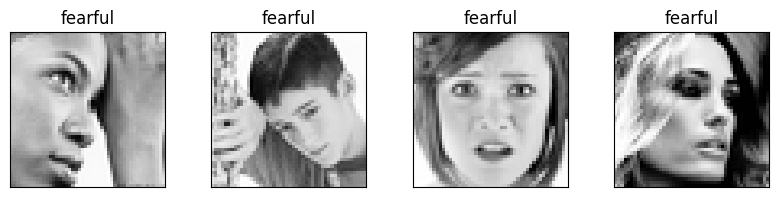

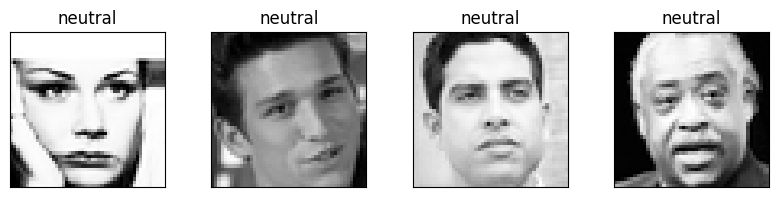

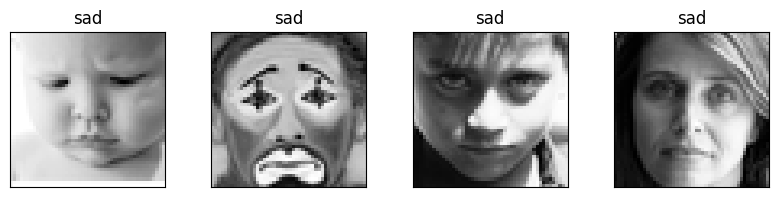

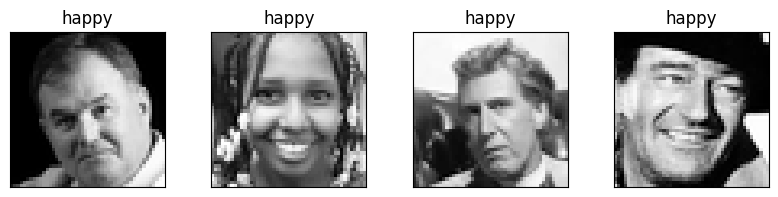

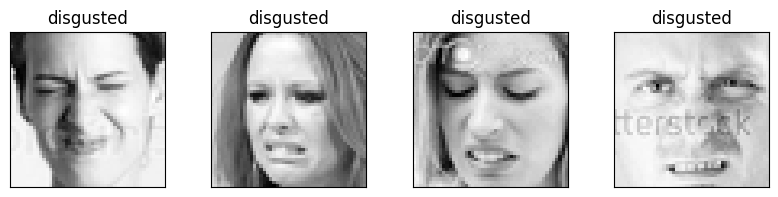

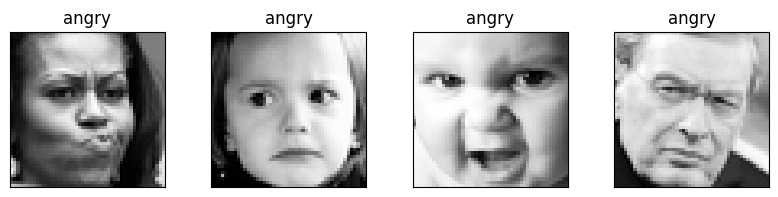

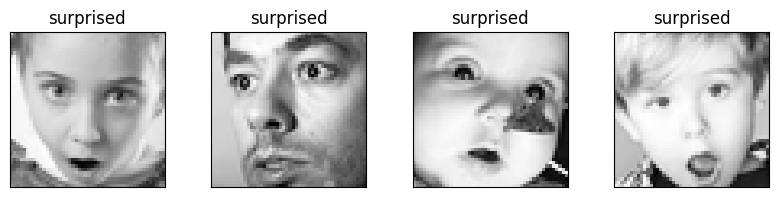

In [15]:
for i in range(len(categories_name_train)):
    plt.figure(figsize=(8,10))
    path = f"./data/train/{categories_name_train[i]}"
    
    for j in range(1,5):
        plt.subplot(3,4,j)
        plt.tight_layout()
        rand_img = Image.open(path +'/'+ np.random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img, cmap='Greys_r')

        # Don't print the X and Y coordinates on the side of the images.
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{categories_name_train[i]}")

### Test data

Explore the categories available in the testing data.

In [16]:
categories_name_test = os.listdir("./data/test/")
print(f"The categories available are in the test data are: \n   {categories_name_test}")
print(f"The test dataset has {len(categories_name_test)} categories.")

The categories available are in the test data are: 
   ['fearful', 'neutral', 'sad', 'happy', 'disgusted', 'angry', 'surprised']
The test dataset has 7 categories.


Check if the categories categories available in the train are also in test, if not raise an error:

In [17]:
for category in categories_name_train:
    if category not in categories_name_test:
        raise ValueError("The categories available in train doesn't match the test data.")

Check if the number of categories are the same in train and test, if not, raise an error:

In [18]:
if len(categories_name_train) != len(categories_name_test):
    raise ValueError("The lenght of the train and test categories doesn't match.")

Check the categories available in the test dataset.

In [19]:
for i in range(len(categories_name_test)):
    path = f"./data/test/{categories_name_test[i]}"
    print(f"The category {categories_name_test[i]} has {len(os.listdir(path))} images.")

The category fearful has 1024 images.
The category neutral has 1233 images.
The category sad has 1247 images.
The category happy has 1774 images.
The category disgusted has 111 images.
The category angry has 958 images.
The category surprised has 831 images.


Plot 4 random images from each of the categories in the test data

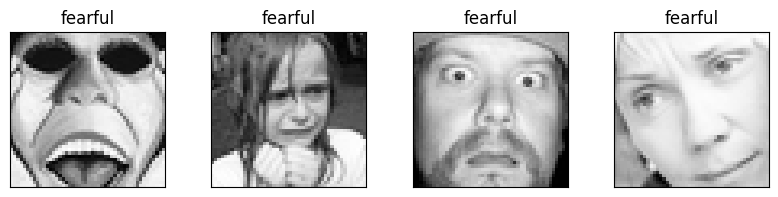

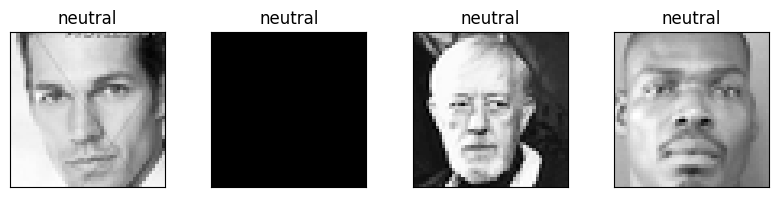

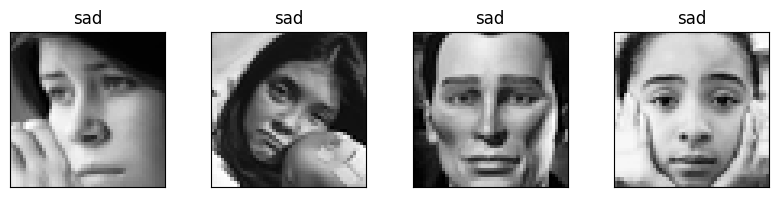

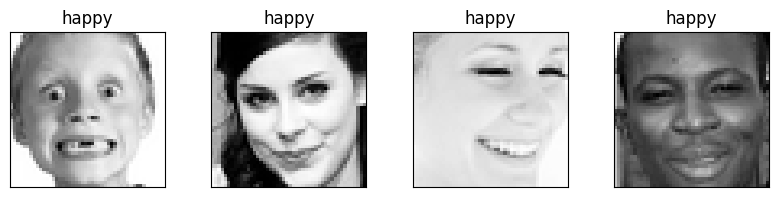

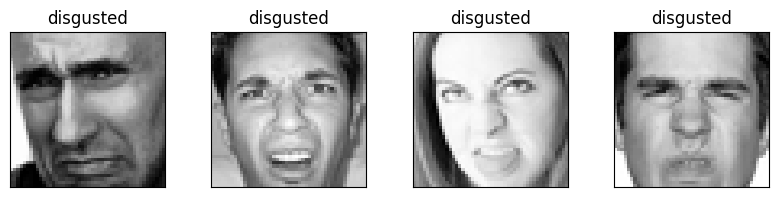

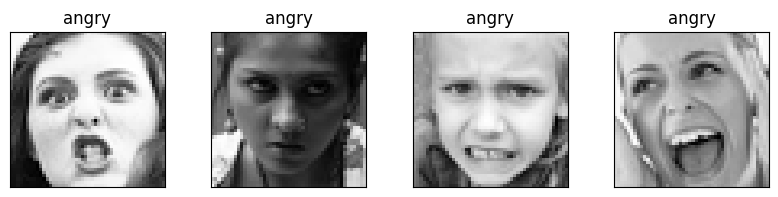

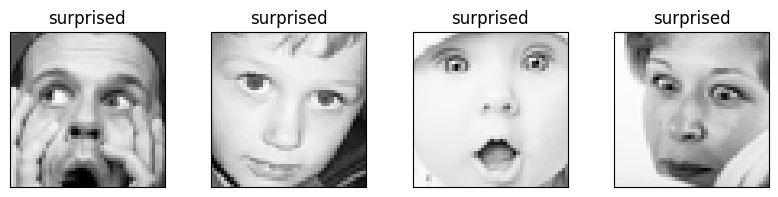

In [20]:
for i in range(len(categories_name_train)):
    plt.figure(figsize=(8,10))
    path = f"./data/train/{categories_name_train[i]}"
    
    for j in range(1,5):
        plt.subplot(3,4,j)
        plt.tight_layout()
        rand_img = Image.open(path +'/'+ np.random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img, cmap='Greys_r')

        # Don't print the X and Y coordinates on the side of the images.
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{categories_name_train[i]}")

---

## Data transformation

### Create tensorflow dataset

Checking the size of one image

In [21]:
image_path = "./data/train/happy/im0.png"
image = Image.open(image_path)
print(f"Image width: {image.width}.")
print(f"Image height: {image.height}.")

Image width: 48.
Image height: 48.


Check if 10 random images extracted from different categories have the same size, otherwhise raise an error message.

In [22]:
for i in range(10):
    random_category = categories_name_train[np.random.randint(7)]
    cat_path = f"./data/train/{random_category}"
    image_idx = np.random.randint(len(os.listdir(cat_path)))
    image_path = f"./data/train/{random_category}/im{image_idx}.png"
    image = Image.open(image_path)
    if i == 0:
        width = image.width
        height = image.height
    if image.width != width or image.height != height:
        raise ValueError(f"Found an image of diferent size:\n({image.width}X{image.height}) != ({width}X{height})")

print(f"The width of the images is {width}.\nThe height of the images is {height}.")

The width of the images is 48.
The height of the images is 48.


Use the `image_dataset_from_directory()` function to process the images and split the data in `training_dataset` and `validation_dataset`.

Referece: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [23]:
training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                    directory = "./data/train", # path to the main folder
                    labels='inferred',  # infer the labels from the parent directory
                    label_mode='int',   # sparse_categorical_crossentropy loss
                    color_mode='grayscale',
                    image_size=(width, height), # add the size of the images so they're not scaled to 256x256
                    shuffle=True,
                    seed=16,
                    verbose=True,
                    batch_size=8, 
                    validation_split=0.1, # reserve a 10% from the training data for validation
                    subset="both", # returns the validation and train data
                    data_format="channels_last",
)

Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Using 2870 files for validation.


Check how many elements have of the training and validation datasets.

In [24]:
print(f"The training dataset has: {len(training_dataset.file_paths)} elements.")
print(f"The validation dataset has: {len(validation_dataset.file_paths)} elements.")

The training dataset has: 25839 elements.
The validation dataset has: 2870 elements.


Check the names of the classes created in train and test are the same

In [25]:
print(f"The validation dataset has these classes:{validation_dataset.class_names}.")
print(f"The training dataset has these classes: {training_dataset.class_names}.")

The validation dataset has these classes:['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'].
The training dataset has these classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'].


Ensure the batch size has the desired shape

In [26]:
for batch in training_dataset:
    print(batch[0][0][:10])
    break

tf.Tensor(
[[[240.]
  [237.]
  [225.]
  [231.]
  [238.]
  [238.]
  [234.]
  [231.]
  [232.]
  [232.]
  [232.]
  [230.]
  [230.]
  [232.]
  [229.]
  [220.]
  [215.]
  [202.]
  [190.]
  [204.]
  [232.]
  [239.]
  [240.]
  [237.]
  [208.]
  [235.]
  [240.]
  [239.]
  [240.]
  [239.]
  [239.]
  [241.]
  [240.]
  [240.]
  [240.]
  [241.]
  [241.]
  [241.]
  [241.]
  [242.]
  [244.]
  [243.]
  [243.]
  [243.]
  [243.]
  [243.]
  [243.]
  [244.]]

 [[240.]
  [238.]
  [237.]
  [240.]
  [238.]
  [237.]
  [235.]
  [235.]
  [237.]
  [237.]
  [238.]
  [238.]
  [238.]
  [239.]
  [238.]
  [239.]
  [235.]
  [227.]
  [208.]
  [203.]
  [222.]
  [238.]
  [240.]
  [234.]
  [210.]
  [235.]
  [239.]
  [239.]
  [238.]
  [233.]
  [237.]
  [240.]
  [239.]
  [239.]
  [240.]
  [240.]
  [241.]
  [240.]
  [241.]
  [241.]
  [242.]
  [242.]
  [243.]
  [243.]
  [242.]
  [243.]
  [244.]
  [243.]]

 [[240.]
  [240.]
  [240.]
  [238.]
  [236.]
  [236.]
  [242.]
  [245.]
  [245.]
  [243.]
  [244.]
  [245.]
  [242.]
  [2

### Data augmentation / distorsion

The dataset has the same images, but they are transformed differently for each epoch. 

**Tensorflow Random Transformation** has been used to transform the images to give to the model more variety. Link to the documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#augment_a_dataset_and_train_a_model_with_it 

In [27]:
print(f"The training dataset has: {len(training_dataset)} elements.")

The training dataset has: 3230 elements.


In [28]:
def augment_data(image, label):
    print(f"first_image: {image}")
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image,lower=0.0, upper=1.0)
    return image, label

training_dataset = training_dataset.map(augment_data)
training_dataset

first_image: Tensor("args_0:0", shape=(None, 48, 48, 1), dtype=float32)


<_MapDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
print(f"The training dataset has: {len(training_dataset)} elements.")

The training dataset has: 3230 elements.


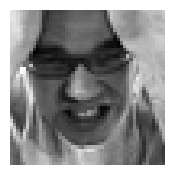

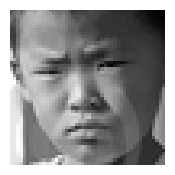

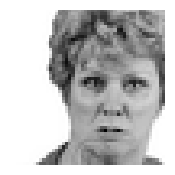

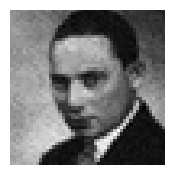

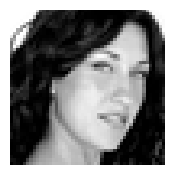

In [30]:
for batch in training_dataset:
    for i in range(5):
        image = batch[0][i]
        plt.figure(figsize=(2, 3))
        plt.imshow(image, cmap='gray')
        # plt.title("Augmented Image")
        plt.axis('off')
        
        plt.show()
    break

---

# Transfer learning


### Create three chanels

Transform each image in the dataset by duplicating its channel. This is needed as the pre-trained model has been trained with RGB images. Link to the `grayscale_to_rgb()` documentation: https://www.tensorflow.org/api_docs/python/tf/image/grayscale_to_rgb 

In [31]:
def create_three_channels(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label


training_dataset = training_dataset.map(create_three_channels)
validation_dataset = validation_dataset.map(create_three_channels)

Check that the images in the batch now have 3 channels.

In [32]:
for batch in training_dataset:
    print(batch[0])
    break

tf.Tensor(
[[[[125.11907  125.11907  125.11907 ]
   [125.73696  125.73696  125.73696 ]
   [126.045906 126.045906 126.045906]
   ...
   [118.167816 118.167816 118.167816]
   [118.2708   118.2708   118.2708  ]
   [118.52825  118.52825  118.52825 ]]

  [[125.06758  125.06758  125.06758 ]
   [125.73696  125.73696  125.73696 ]
   [126.045906 126.045906 126.045906]
   ...
   [118.21931  118.21931  118.21931 ]
   [117.91036  117.91036  117.91036 ]
   [118.064835 118.064835 118.064835]]

  [[125.06758  125.06758  125.06758 ]
   [125.78845  125.78845  125.78845 ]
   [126.0974   126.0974   126.0974  ]
   ...
   [119.96999  119.96999  119.96999 ]
   [119.30061  119.30061  119.30061 ]
   [118.57974  118.57974  118.57974 ]]

  ...

  [[123.47137  123.47137  123.47137 ]
   [123.419876 123.419876 123.419876]
   [123.316895 123.316895 123.316895]
   ...
   [123.16242  123.16242  123.16242 ]
   [121.51472  121.51472  121.51472 ]
   [119.60956  119.60956  119.60956 ]]

  [[121.978134 121.978134 121.9781

### Preprocess the images with the specific preprocessor

Link to the preprocess function for ResNet50: https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input

In [33]:
# tf.keras.applications.resnet.preprocess_input(training_dataset)

In [34]:
def preprocess_with_resnet_preprocessor(image, label):
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image, label


training_dataset = training_dataset.map(preprocess_with_resnet_preprocessor)
validation_dataset = validation_dataset.map(preprocess_with_resnet_preprocessor)

In [35]:
for batch in training_dataset:
    print(batch[0])
    break

tf.Tensor(
[[[[ 77.51498     64.67498     57.77398   ]
   [ 89.84176     77.00176     70.10076   ]
   [ 93.950676    81.11068     74.20968   ]
   ...
   [ 94.53768     81.697685    74.796684  ]
   [ 94.53768     81.697685    74.796684  ]
   [ 94.53768     81.697685    74.796684  ]]

  [[ 81.62389     68.7839      61.882896  ]
   [ 92.18972     79.349724    72.44872   ]
   [ 94.53768     81.697685    74.796684  ]
   ...
   [ 94.53768     81.697685    74.796684  ]
   [ 94.53768     81.697685    74.796684  ]
   [ 94.53768     81.697685    74.796684  ]]

  [[ 87.4938      74.6538      67.7528    ]
   [ 93.950676    81.11068     74.20968   ]
   [ 94.53768     81.697685    74.796684  ]
   ...
   [ 94.53768     81.697685    74.796684  ]
   [ 94.53768     81.697685    74.796684  ]
   [ 94.53768     81.697685    74.796684  ]]

  ...

  [[-17.577263   -30.41726    -37.31826   ]
   [-12.881348   -25.721344   -32.622345  ]
   [ 14.707138     1.8671417   -5.0338593 ]
   ...
   [-32.25199    -45.091

## Transfer learning model

Import the pretrained model


In [36]:
from keras.applications.resnet import ResNet50

Instantiate the base model

In [37]:
base_model = ResNet50(
    include_top = False,
    input_shape = (48, 48, 3),
    classes = 7,
    
)
print(f"The output of the base model is: {base_model.output}")

# # Pass all base model's layers to not trainable
# for layer in base_model.layers:
#     layer.trainable = False

# Check out the base model summary
# base_model.summary()

The output of the base model is: <KerasTensor shape=(None, 2, 2, 2048), dtype=float32, sparse=False, name=keras_tensor_174>


In [38]:
# print(f"The base model has these layers: {base_model.layers}")

Add the extra trainable layers to the base model

In [39]:
y = GlobalAveragePooling2D()(base_model.output)
y = Dense(20, activation="relu")(y)
y = Dense(7, activation="softmax")(y)

model = Model(base_model.inputs, y)


In [40]:
model.compile(optimizers.Adam(0.0001),
    loss="sparse_categorical_crossentropy",
    metrics =["accuracy"],)

In [41]:
 model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 23,628,839 (90.14 MB)

 Trainable params: 23,575,719 (89.93 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [42]:
hist = model.fit(
    training_dataset,
    batch_size=8,
    epochs=20,
    verbose="auto",
    validation_data=validation_dataset,
    shuffle=True, 
)

Epoch 1/20


/home/ivallesp/projects/emotion_detection/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


3230/3230 ━━━━━━━━━━━━━━━━━━━━ 707s 213ms/step - accuracy: 0.3525 - loss: 1.7042 - val_accuracy: 0.4993 - val_loss: 1.3592
Epoch 2/20
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 691s 214ms/step - accuracy: 0.5020 - loss: 1.3354 - val_accuracy: 0.5251 - val_loss: 1.2820
Epoch 3/20
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 692s 214ms/step - accuracy: 0.5499 - loss: 1.1986 - val_accuracy: 0.5328 - val_loss: 1.2495
Epoch 4/20
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 692s 214ms/step - accuracy: 0.5884 - loss: 1.1056 - val_accuracy: 0.5659 - val_loss: 1.2093
Epoch 5/20
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 692s 214ms/step - accuracy: 0.6268 - loss: 1.0152 - val_accuracy: 0.5617 - val_loss: 1.2381
Epoch 6/20
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 692s 214ms/step - accuracy: 0.6519 - loss: 0.9426 - val_accuracy: 0.5763 - val_loss: 1.2255
Epoch 7/20
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 691s 214ms/step - accuracy: 0.6836 - loss: 0.8606 - val_accuracy: 0.5495 - val_loss: 1.3957
Epoch 8/20
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 691s 214ms/step - accuracy: 0.7

In [43]:
max(hist.history["val_accuracy"])

0.5926828980445862

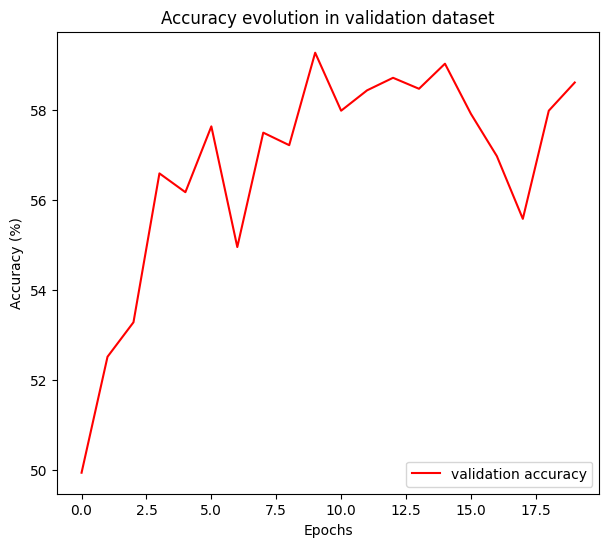

In [44]:
# Plot the accuracy in each epoch for the validation dataset
fig, ax = plt.subplots(1,1, figsize = (7,6))
ax.plot(np.array(hist.history["val_accuracy"])*100, label="validation accuracy", color="red")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy evolution in validation dataset")
ax.legend(loc = "lower right")
plt.show()

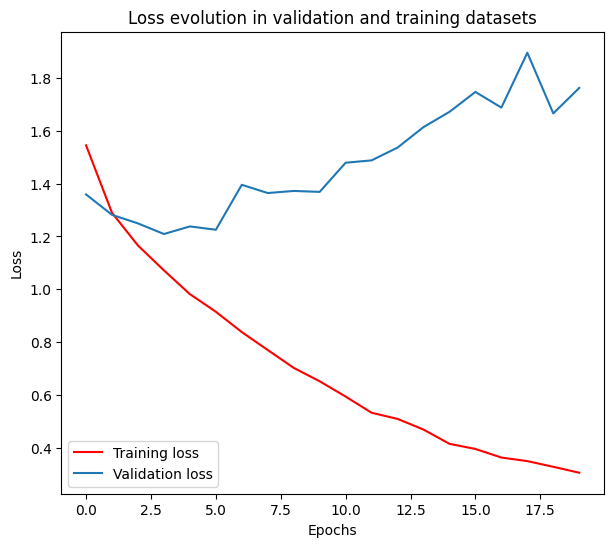

In [45]:
# Plot the Loss in each epoch for the training and validation datasets
fig2, ax = plt.subplots(1,1, figsize = (7,6))
ax.plot(hist.history["loss"], label="Training loss", color = "red")
ax.plot(hist.history["val_loss"], label="Validation loss")
#plt.xlim(0, 10)
#plt.ylim(0, 4)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution in validation and training datasets")
ax.legend(loc = "lower left")
plt.show()

## Save the data

Save the miodel params and images

In [46]:
# Create the dictionary with the model params and the metadata
state_dict = {
            "model_cls": str(model.__class__),
            "params": model.to_json(),
            "metrics":{
                "training_accuracy": hist.history["accuracy"],
                "training_loss": hist.history["loss"],
                "validation_accuracy": hist.history["val_accuracy"],
                "validation_loss": hist.history["val_loss"],
            },
            "meta":{
                "date": datetime.now().isoformat(),
                "student": "Maria Magdalena Balos",
                "course": "DATAMECUM-IA GENERATIVE MASTER",
            },
            }

# Save the json file
dirname = f"{datetime.now().isoformat()}"+"-"+ "CNN"
out_dir = os.path.join(".", "results", dirname)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    with open(os.path.join(out_dir, "state_dict.json"), "w") as f:
        json.dump(state_dict,f, indent=4)
    fig.savefig(os.path.join(out_dir, "accuracy_val.pdf"))
    fig2.savefig(os.path.join(out_dir, "loss_train_val.pdf"))

Save the model